# POKMeans

Hello there!!! 

In simple words, the Clustering aim is to segregate groups with similar traits and assign them into clusters. It may help you defining actions for a group of elements instead of dealing one by one, and elements could be customers, tasks, students, projects, products ... and Pokemons!

So in this notebook, I am going to apply KMeans on Pokemon Stats, could we get good clusters based on Pokemons Skills?

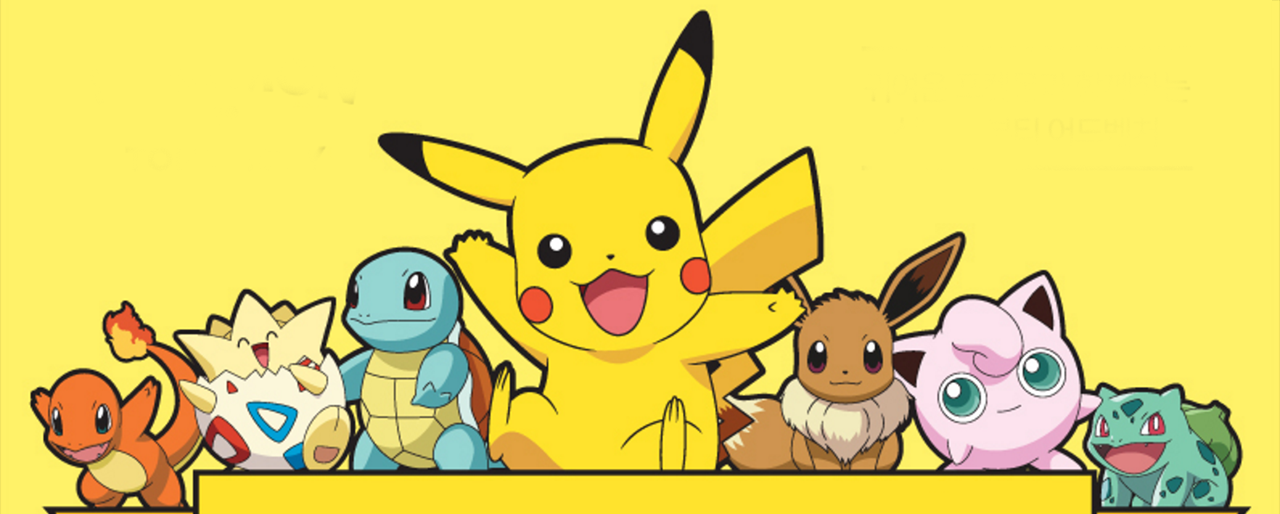

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
Pokedex = pd.read_csv("../input/pokemon/Pokemon.csv")
Pokedex["Type 2"].fillna("-", inplace = True)
Pokedex

Before clustering, let's take a look on Pokemons Skills.

Boxplot give us the basic stats of each feature.

In [ ]:

BoxPlotPkdex = pd.melt(Pokedex, id_vars = [
    "#", 
    "Name", 
    "Type 1", 
    "Type 2", 
    "Generation"
    ], value_vars = [
    #"Total",
    "HP", "Attack", "Defense", "Sp. Atk",
    "Sp. Def", "Speed"    
])
plt.figure(figsize=(12,5))
ax = sns.boxplot(x="variable", y="value", data=BoxPlotPkdex)
plt.title("Skills Boxplot")
plt.xlabel("Skills")
plt.ylabel("Value");



In Pairplor we can check how features are related to each other.

In [ ]:
sns.pairplot(Pokedex[['Total', 'HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed']]);

# KMeans

**KMeans is easy to understand and very practical to use, it is very useful to give you quick insights about the data you are studying. It is very useful for a variety of applications such as market segmentation, document clustering, image segmentation and image compression, etc.**

The video below, StatQuest show us how KMeans Method works :)

<iframe width="598" height="338" src="https://www.youtube.com/embed/4b5d3muPQmA" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In KMeans, we need to set the number of clusters (K = number of clusters) and sometimes you lack knowledge of the problem or it is hard to identify the best K by taking a look at the descriptive and exploratory analysis. 

Even if you could be able to set an initial number of cluster based on your problem's knowledge, it's good advice to check the elbow method or silhouette analysis to confirm how many clusters would fit better in your KMeans Method.

# Feature selection
As described in dataset infos, Total: the sum of all stats that come after this, a general guide to how strong a pokemon is. So it will not be used as a feature in this model.
The features used are the Skills below:
* Attack: the base modifier for normal attacks (eg. Scratch, Punch)
* Defense: the base damage resistance against normal attacks
* SP Atk: special attack, the base modifier for special attacks (e.g. fire blast, bubble beam)
* SP Def: the base damage resistance against special attacks
* Speed: determines which pokemon attacks first each round


The Heat Map below shows us how features are correlated.

In [ ]:
# Features correlation
Skills = [ 'HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed']
sns.heatmap(Pokedex[Skills].corr(),cmap="YlGnBu", annot=True);
plt.title("Feature Correlation Map");

# The Elbow Method

The Elbow method will help us to determine the ideal number of clusters for the KMeans model by minimizing Inertia.

KMeans calculates the distance between the sample points and the center point of the cluster they belong to, the best scenario is the one where distances of the center points are the smallest possible (take care with overfitting).

In practice, the  [K-means algorithm ](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) is one of the fastest clustering algorithms available, so we can run it in a for loop with a range of the number of clusters and check the KMeans attribute named Inertia.

    inertia_ : float
        Sum of squared distances of samples to their closest cluster center.



In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
#import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
StdScale = scale.fit_transform(Pokedex[Skills])

n_max_clusters = 15
# Elbow Method
score = []
for cluster in range(1,n_max_clusters):
    kmeans_f = KMeans(n_clusters = cluster, init="k-means++", random_state=10)
    kmeans_f.fit(StdScale)
    score.append(kmeans_f.inertia_)

In [ ]:
# plotting elbow graphics

plt.plot(range(1,n_max_clusters), score)
plt.scatter(range(1,n_max_clusters), score)

plt.title('The Elbow Chart')
plt.xlabel('number of clusters')
plt.ylabel('Inertia')

n = 5
plt.annotate(f"Number of clusters = {n}", xy=(n, score[n]), xytext=(n-3, score[n]*0.8), arrowprops=dict(arrowstyle="->"))


plt.show()

In [ ]:
# Running the model with number of clusters determined by Elbow MEthod
kmeans = KMeans(n_clusters = n, init="k-means++", random_state=10)
kmeans.fit(StdScale)
Pokedex["Clusters"] = kmeans.labels_

Centroids = pd.DataFrame(scale.inverse_transform(kmeans.cluster_centers_))
Centroids.columns = Skills
Centroids["Clusters"] = [0,1,2,3,4]

# Exploring the Clusters KMeans found
Let's take a look at the particulars of Clusters we found using the KMeans Method.

First, we have here pairplot now with Clusters KMeans has found.

In [ ]:
sns.pairplot(Pokedex[['Total', 'HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed', "Clusters"]], hue = "Clusters");

In the pair plot above, we can already see that Cluster 1 (orange dots) are the strongest group of Pokemons with a high number of points in almost all skills. On the other hand, Cluster 0 (blue dots) are the weakest group.

The groups in between are mixed and seem to have some particularity in each skill, it is hard to determine their characteristics by taking a look at pairplot

In [ ]:

BoxPlotPkdex = pd.melt(Pokedex, id_vars = [
    "#", 
    "Name", 
    "Type 1", 
    "Type 2", 
    "Generation",
    "Clusters"
    ], value_vars = [
    #"Total",
    "HP", "Attack", "Defense", "Sp. Atk",
    "Sp. Def", "Speed"    
])
plt.figure(figsize=(12,5))
ax = sns.boxplot(x="variable", y="value", hue = "Clusters", data=BoxPlotPkdex)
plt.title("Skills Boxplot")
plt.xlabel("Skills")
plt.ylabel("Value");



In [ ]:
GroupedPokedex = Pokedex.groupby(["Clusters"])


In [ ]:
Centroids.astype(int)

In [ ]:
Pokedex.groupby(["Clusters"]).agg({
    'HP': 'median', 
    'Attack': 'median', 
    'Defense': 'median', 
    'Sp. Atk': 'median', 
    'Sp. Def': 'median', 
    'Speed': 'median'})

Plotting the Mean and the Median of the Clusters Skills in a Radar Chart may show us their main characteristics.

Note: You can use .clusters_center attribute to get the means for each skill used in KMeans Method

    cluster_centers_ : ndarray of shape (n_clusters, n_features)
        Coordinates of cluster centers. If the algorithm stops before fully converging (see tol and max_iter), these will not be consistent with labels_.

For radar charts, I do recommend [Flourish](https://flourish.studio/).
It provides us many chart samples that you can use and save you a lot of work time coding to plot in Python.

<iframe src='https://flo.uri.sh/visualisation/5070209/embed' title='Interactive or visual content' frameborder='0' scrolling='no' style='width:100%;height:300px;'></iframe><div style='width:100%!;margin-top:4px!important;text-align:right!important;'><a class='flourish-credit' href='https://public.flourish.studio/visualisation/5070209/?utm_source=embed&utm_campaign=visualisation/5070209' target='_top' style='text-decoration:none!important'><img alt='Made with Flourish' src='https://public.flourish.studio/resources/made_with_flourish.svg' style='width:105px!important;height:16px!important;border:none!important;margin:0!important;'> </a></div>


The Medians are quite similar to the Means

<iframe src='https://flo.uri.sh/visualisation/5070399/embed' title='Interactive or visual content' frameborder='0' scrolling='no' style='width:100%;height:300px;'></iframe><div style='width:100%!;margin-top:4px!important;text-align:right!important;'><a class='flourish-credit' href='https://public.flourish.studio/visualisation/5070399/?utm_source=embed&utm_campaign=visualisation/5070399' target='_top' style='text-decoration:none!important'><img alt='Made with Flourish' src='https://public.flourish.studio/resources/made_with_flourish.svg' style='width:105px!important;height:16px!important;border:none!important;margin:0!important;'> </a></div>

In [ ]:
GroupedPokedex.get_group(4).sort_values("HP")
#.sample(5)#
# EX: Caterpie, Porygon and Magikarp
#EX: AegislashBlade Forme, Kyogre Primal and MewtwoMega Mewtwo Y
# EX: Accelgor, Ninjask and Crobat
# EX: Shuckle, Regirock and Steelix

In [ ]:
Pokedex.to_csv("PokedexCluster.csv", index=False)

Radar plot, Boxplot, and Pairplot give us the main features of each Cluster given by the KMeans model.

## Cluster 0 = Weakest Pokemons Cluster
> The weakest Pokemons, low values for all the Skills

> EX: Caterpie, Porygon and Magikarp

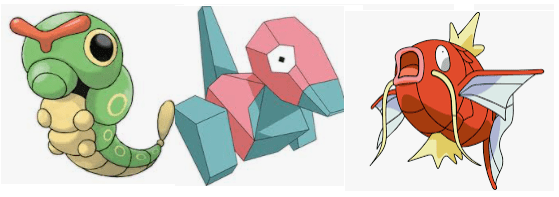

## Cluster 1 = The Overpowering Squad
> The strongest Pokemons have high values for all skills

> Speed, Attack and Special Attack are the top 3 skills

> EX: AegislashBlade Forme, Kyogre Primal and Mewtwo Mega Mewtwo Y

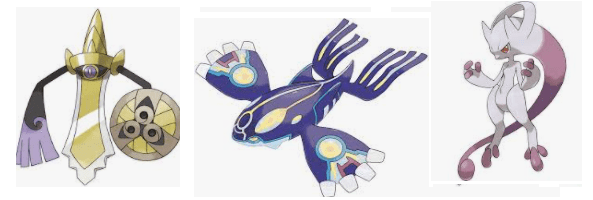

Clusters 2, 3, and 4 are in the middle between Cluster 0 and 1.

## Cluster 2 = Speedy Squad
> Cluster of the fastest Pokemons

> Speed, Attack and Special Attack are the Top 3 Skills

> EX: Accelgor, Ninjask and Crobat

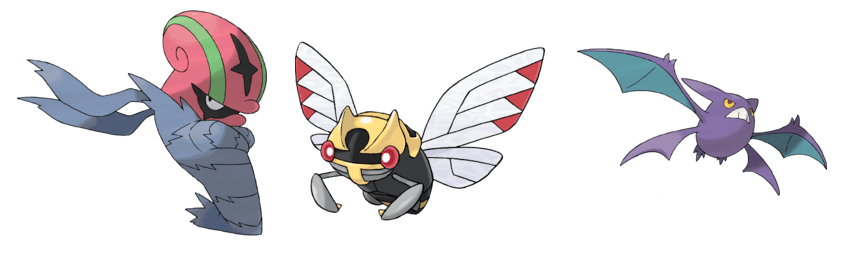

## Cluster 3 = The Defensive Squad
> The highest Skills are Defense and Special Defense

> Defensive, Special Defense and Attack are the Top 3 Skills 

> EX: Shuckle, Regirock and Steelix

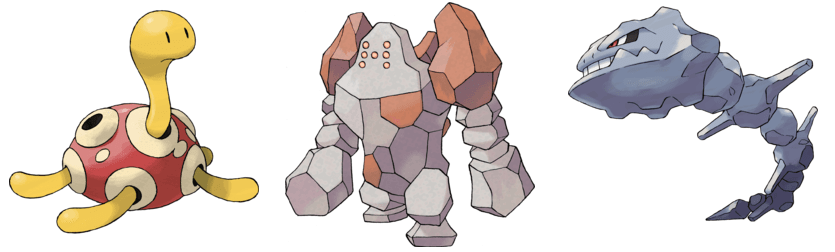

## Cluster 4 = High HP and Slow Speed Cluster

> They have High HP and Slow Speed

> HP, Attack and Special Defense are the top 3 skills

> EX: Blissey, Chansey and Wobbuffet

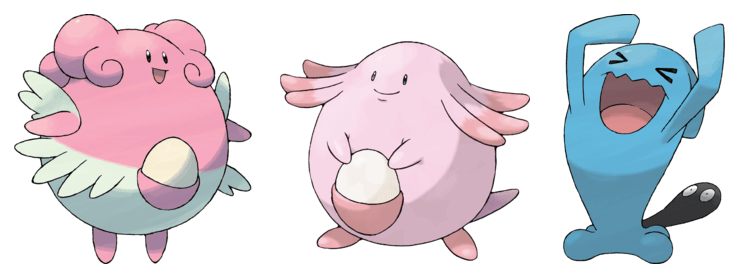

# POKMeans Clusters - Flourish Viz



Complete viz of pokemon and clusters

<iframe src='https://flo.uri.sh/visualisation/5094527/embed' title='Interactive or visual content' frameborder='0' scrolling='no' style='width:100%;height:600px;'></iframe><div style='width:100%!;margin-top:4px!important;text-align:right!important;'><a class='flourish-credit' href='https://public.flourish.studio/visualisation/5094527/?utm_source=embed&utm_campaign=visualisation/5094527' target='_top' style='text-decoration:none!important'><img alt='Made with Flourish' src='https://public.flourish.studio/resources/made_with_flourish.svg' style='width:105px!important;height:16px!important;border:none!important;margin:0!important;'> </a></div>

KMeans helped me to identify some clusters and their main features based on Pokemon's skills stats, but Pokemons could be Customers, Workers, Students, Salesperson or Products and Skills could be Revenue, Performance, Grades, Sales, Number of clicks...

So, could you identify where to apply KMeans in your business problems?

All feedbacks are welcome :)